In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import copy
import datetime
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels
from scipy import stats
from pingouin import pairwise_ttests

In [2]:
airlines=pd.read_csv('airlines.csv')
airports=pd.read_csv('airports.csv',encoding = "latin")
traffic = pd.read_csv('flight_traffic.csv')
stock = pd.read_csv('stock_prices.csv')
updated_events = pd.read_csv('event_dates_df.csv')

### Work on getting the stock return for an airline on a particular day

In [3]:
cols = ['AA', 'UA', 'B6', 'OO', 'AS', 'NK', 'WN', 'DL', 'HA']
for i in cols:
    stock['returns'+i] = stock[i][:-1].values / stock[i][1:] - 1

In [4]:
stock_returns = stock[['timestamp','returnsAA', 'returnsUA', 'returnsB6', 'returnsOO', 'returnsAS', 'returnsNK', 
                       'returnsWN', 'returnsDL', 'returnsHA']]
stock = stock[['timestamp','AA','UA','B6','OO','AS','NK','WN','DL','HA']]

In [5]:
melted_st = pd.melt(stock,id_vars=['timestamp'],
                        value_vars=['AA','UA','B6','OO','AS','NK','WN','DL','HA'],
                        var_name='airline_codes',value_name='price')

melted_rt = pd.melt(stock_returns,id_vars=['timestamp'],
                        value_vars=['returnsAA', 'returnsUA', 'returnsB6', 'returnsOO', 'returnsAS', 
                                    'returnsNK', 'returnsWN', 'returnsDL', 'returnsHA'],
                        var_name='airline_codes',value_name='returns')

melted_rt['airline_codes'] = melted_rt['airline_codes'].apply(lambda x: x[-2:])
melted_stock = pd.merge(melted_st, melted_rt, on=['airline_codes','timestamp'])

In [6]:
melted_stock['year'] = pd.DatetimeIndex(melted_stock['timestamp']).year
melted_stock['month'] = pd.DatetimeIndex(melted_stock['timestamp']).month
melted_stock['day'] = pd.DatetimeIndex(melted_stock['timestamp']).day

In [7]:
#Merge stock and traffic data
stock_traffic = pd.merge(traffic, melted_stock, left_on=['year','month','day','airline_id'], 
                         right_on = ['year','month','day','airline_codes'])

### Converting the scheduled arrival and departure in a cleaned format

In [8]:
cols = stock_traffic.columns.difference(['year','month','day','airline_id','origin_airport','destination_airport',
                                        'taxi_out','taxi_in','cancelled','diverted','scheduled_elapsed',
                                         'actual_elapsed','distance', 'airline_delay', 'weather_delay',
                                         'air_system_delay', 'security_delay', 'aircraft_delay', 'airline_codes',
                                         'price', 'timestamp','returns'])

In [9]:
for c in cols:
    stock_traffic[c] = stock_traffic[c].fillna(0).astype('int32').astype(str)
    stock_traffic[c] = stock_traffic[c].apply(lambda x: x.rjust(4,'0'))

In [10]:
stock_traffic[cols] = stock_traffic[cols].apply(lambda x: pd.to_timedelta(x.str[:-2] + ':' + x.str[-2:] + ':00'))

In [11]:
for c in cols:
    stock_traffic[c] = pd.to_datetime(stock_traffic[c]).apply(lambda x: datetime.datetime.time(x))

/Users/dhams/Desktop/DS4A_workspace/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Passing timedelta64-dtype data is deprecated, will raise a TypeError in a future version
  
/Users/dhams/Desktop/DS4A_workspace/venv/lib/python3.7/site-packages/pandas/util/_decorators.py:208: FutureWarning: Passing timedelta64-dtype data is deprecated, will raise a TypeError in a future version
  return func(*args, **kwargs)


In [12]:
stock_traffic = stock_traffic.drop(columns='airline_codes')

### Substituting 0s in place of Nan in the delay column of the traffic

In [13]:
columns = ['airline_delay', 'weather_delay','air_system_delay', 'security_delay', 'aircraft_delay']
for c in columns:
    stock_traffic[c] = stock_traffic[c].apply(lambda x: 0 if np.isnan(x) else x)

In [14]:
# Calulating the total delay time for a traffic
stock_traffic['delay_time'] = stock_traffic['airline_delay']+stock_traffic['weather_delay']
+stock_traffic['security_delay']+stock_traffic['air_system_delay']+stock_traffic['aircraft_delay']

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
367986    0.0
367987    0.0
367988    0.0
367989    0.0
367990    0.0
Length: 367991, dtype: float64

Text(0.5, 1.0, 'Mean delay time for every flight on event days')

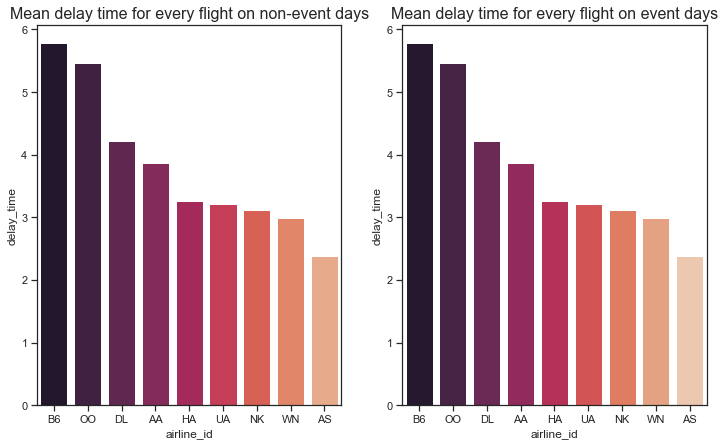

In [110]:
mean_delay_noEvent = pd.DataFrame(stock_traffic.groupby('airline_id')['delay_time'].mean()
                                .sort_values(ascending=False)).reset_index()
mean_delay_Event = pd.DataFrame(updated_events.groupby('airline_id')['delay_time'].mean()
                                .sort_values(ascending=False)).reset_index()

a4_dims = (12, 7)
fig, ax = plt.subplots(1,2,figsize=a4_dims)
sns.barplot(x="airline_id", y="delay_time",palette=sns.color_palette("rocket", 10), 
            data=mean_delay_noEvent,ax=ax[0]).set_title('Mean delay time for every flight on non-event days',size=16)
sns.barplot(x="airline_id", y="delay_time", palette="rocket",
            data=mean_delay_noEvent,ax=ax[1]).set_title('Mean delay time for every flight on event days',size=16)

Text(0.5, 1.0, 'Stock Price distribution for event days')

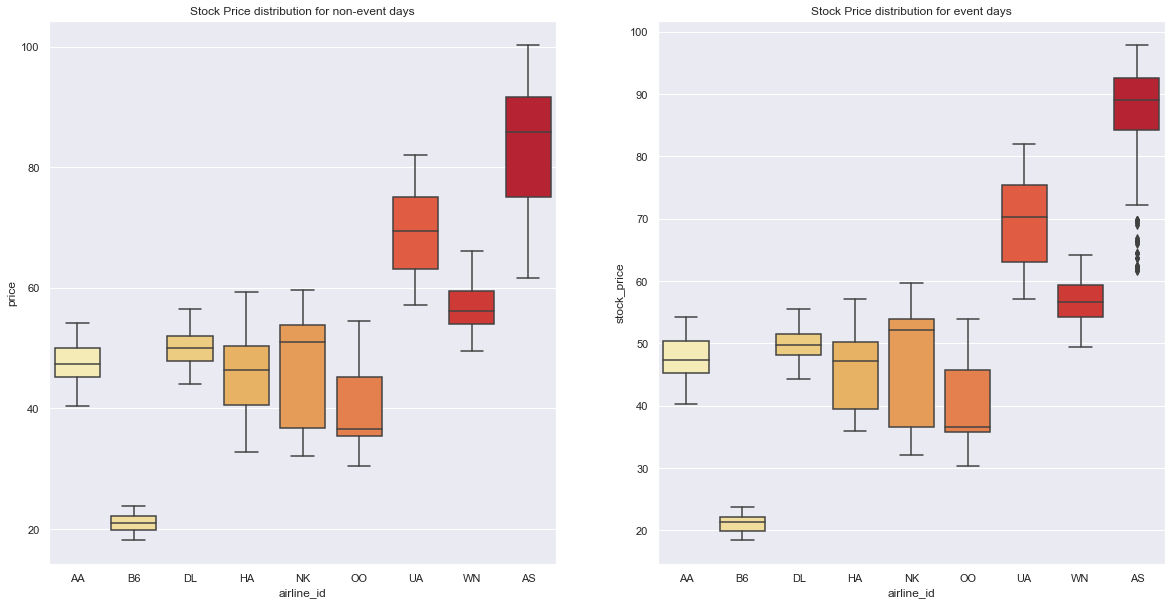

In [137]:
a4_dims = (20, 10)
fig, ax = plt.subplots(1,2,figsize=a4_dims)
sns.set(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes='g', rc=None)
sns.boxplot(x="airline_id", y="price", data=stock_traffic,ax=ax[0],palette=sns.color_palette("YlOrRd", 10),
            order=['AA','B6','DL','HA','NK','OO','UA','WN','AS']).set_title("Stock Price distribution for non-event days")
sns.boxplot(x="airline_id", y="stock_price", data=updated_events,ax=ax[1],palette=sns.color_palette("YlOrRd", 10),
            order=['AA','B6','DL','HA','NK','OO','UA','WN','AS']).set_title("Stock Price distribution for event days")

In [119]:
mean_return_data = pd.merge(pd.DataFrame(updated_events.groupby('airline_id')['return'].mean()).reset_index(),
                       pd.DataFrame(stock_traffic.groupby('airline_id')['returns'].mean()).reset_index(),
                       on='airline_id')
mean_return_data.columns = ['airline_id','event','no_event']
mean_return_data.head()

,airline_id,event,no_event
0,AA,0.000171,0.000748
1,AS,0.004086,-0.000610
2,B6,0.002343,0.000136
3,DL,0.001948,0.000655
4,HA,0.002997,-0.001789


In [53]:
melted_return = pd.melt(mean_return_data,id_vars=['airline_id'],
                        value_vars=['event','no_event'],
                        var_name='type_of_day',value_name='returns')
melted_return.head()

,airline_id,type_of_day,returns
0,AA,event,0.000171
1,AS,event,0.004086
2,B6,event,0.002343
3,DL,event,0.001948
4,HA,event,0.002997


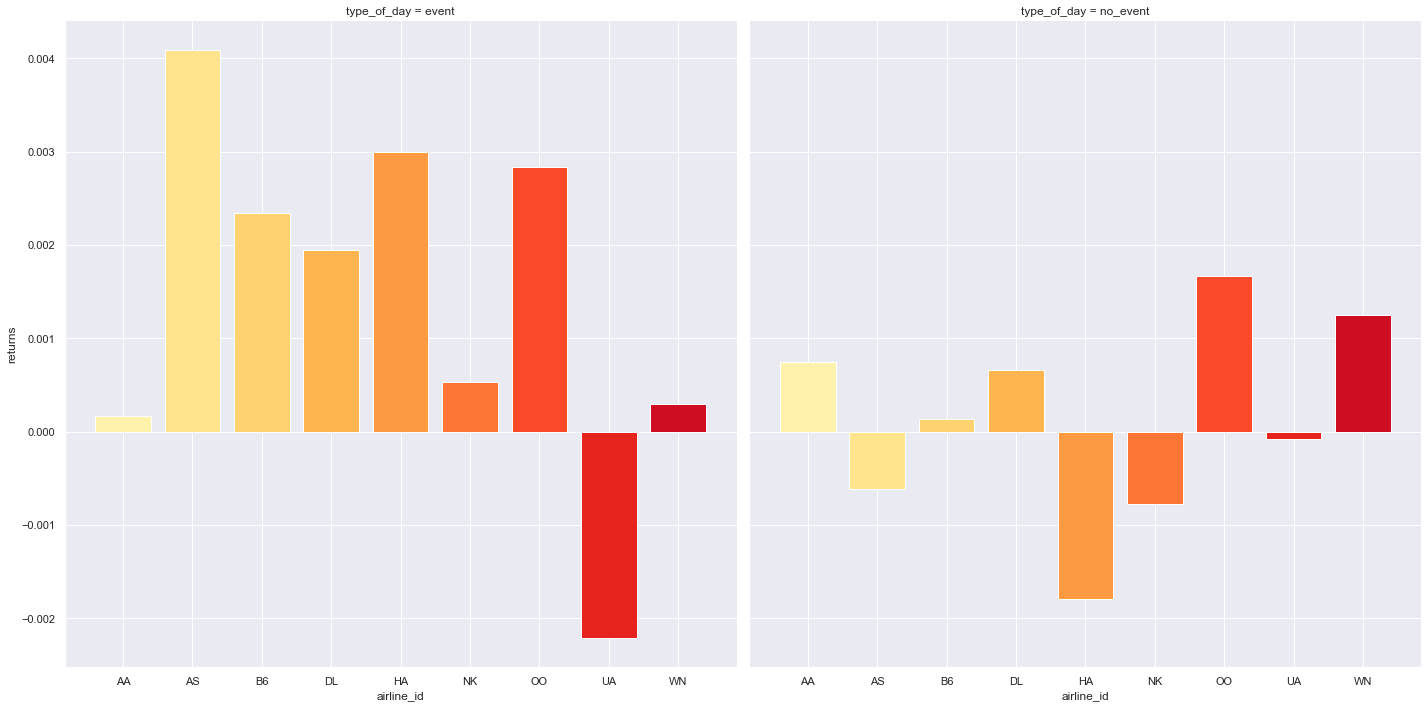

In [138]:
g = sns.FacetGrid(melted_return, col="type_of_day",hue='airline_id',height=10,palette=sns.color_palette("YlOrRd", 10))
g.map(plt.bar, "airline_id", "returns")

In [ ]:
event = ['B6','DL','HA','NK','AS','OO']
non_event=['AA','UA','WN']

### Are the means return of the event and no event days groups significantly different? 

In [38]:
airlines[airlines['airline_id']=='WN']

,airline_id,airline_name
3,WN,Southwest Airlines Co.


In [23]:
## JetBlue B6:
statistic, pvalue = stats.ttest_ind(stock_traffic[stock_traffic.airline_id=='B6']['returns'], 
                                    updated_events[updated_events.airline_id=='B6']['return'], equal_var=False)
print("P-value:",pvalue)

P-value: 5.987237629108067e-08


In [25]:
## Delta Airlines DL:
statistic, pvalue = stats.ttest_ind(stock_traffic[stock_traffic.airline_id=='DL']['returns'], 
                                    updated_events[updated_events.airline_id=='DL']['return'], equal_var=False)
print("P-value:",pvalue)

P-value: 5.951923196856152e-07


In [27]:
## Hawaiian HA:
statistic, pvalue = stats.ttest_ind(stock_traffic[stock_traffic.airline_id=='HA']['returns'], 
                                    updated_events[updated_events.airline_id=='HA']['return'], equal_var=False)
print("P-value:",pvalue)

P-value: 0.22609560431867037


In [29]:
## Spirit Airlines
statistic, pvalue = stats.ttest_ind(stock_traffic[stock_traffic.airline_id=='NK']['returns'], 
                                    updated_events[updated_events.airline_id=='NK']['return'], equal_var=False)
print("P-value:",pvalue)

P-value: 0.12588633046689335


In [31]:
## Alaska AS
statistic, pvalue = stats.ttest_ind(stock_traffic[stock_traffic.airline_id=='AS']['returns'], 
                                    updated_events[updated_events.airline_id=='AS']['return'], equal_var=False)
print("P-value:",pvalue)

P-value: 2.166368135939707e-06


In [33]:
## American AA
statistic, pvalue = stats.ttest_ind(stock_traffic[stock_traffic.airline_id=='AA']['returns'], 
                                    updated_events[updated_events.airline_id=='AA']['return'], equal_var=False)
print("P-value:",pvalue)

P-value: 0.09424409127591074


In [35]:
## Skywest OO
statistic, pvalue = stats.ttest_ind(stock_traffic[stock_traffic.airline_id=='OO']['returns'], 
                                    updated_events[updated_events.airline_id=='OO']['return'], equal_var=False)
print("P-value:",pvalue)

P-value: 0.025225205181498924


In [37]:
## United UA
statistic, pvalue = stats.ttest_ind(stock_traffic[stock_traffic.airline_id=='UA']['returns'], 
                                    updated_events[updated_events.airline_id=='UA']['return'], equal_var=False)
print("P-value:",pvalue)

P-value: 0.0007367729225862906


In [39]:
## Southwest WN
statistic, pvalue = stats.ttest_ind(stock_traffic[stock_traffic.airline_id=='WN']['returns'], 
                                    updated_events[updated_events.airline_id=='WN']['return'], equal_var=False)
print("P-value:",pvalue)

P-value: 2.3297185332180505e-06


Statistical difference of the mean return between event and non-event days are for airlines - JetBlue, Delta, Alaska, Skywest, United and Southwest Airlines. For JetBlue, Delta, Alaska, Skywest mean stock return is better for event days while for United and Southwest we have better stock returns for non-event days.

In [72]:
event_subset = updated_events[['airline_id','return','delay_time']]
event_subset = event_subset.loc[event_subset['airline_id'].isin(['B6','DL','AS','OO'])]
event_subset.head()

,airline_id,return,delay_time
5154,B6,-0.004632,0.0
5155,B6,-0.004632,0.0
5156,B6,-0.004632,0.0
5157,B6,-0.027039,164.0
5158,B6,-0.027039,0.0


In [74]:
delayEvent = event_subset[event_subset.delay_time>30]
noDelayEvent = event_subset[event_subset.delay_time<=30]

In [75]:
mean_delayEvent = delayEvent.groupby('airline_id')['return'].mean().reset_index()
mean_delayEvent.columns = ['airline_id','Yes']
mean_noDelayEvent = noDelayEvent.groupby('airline_id')['return'].mean().reset_index()
mean_noDelayEvent.columns = ['airline_id','No']
melted_delays = pd.melt(pd.merge(mean_delayEvent,mean_noDelayEvent,on='airline_id'),id_vars=['airline_id'],
                        value_vars=['Yes','No'],
                        var_name='delayed',value_name='returns')
melted_delays.head()

,airline_id,delayed,returns
0,AS,Yes,0.006125
1,B6,Yes,0.004255
2,DL,Yes,0.002720
3,OO,Yes,0.001226
4,AS,No,0.003845


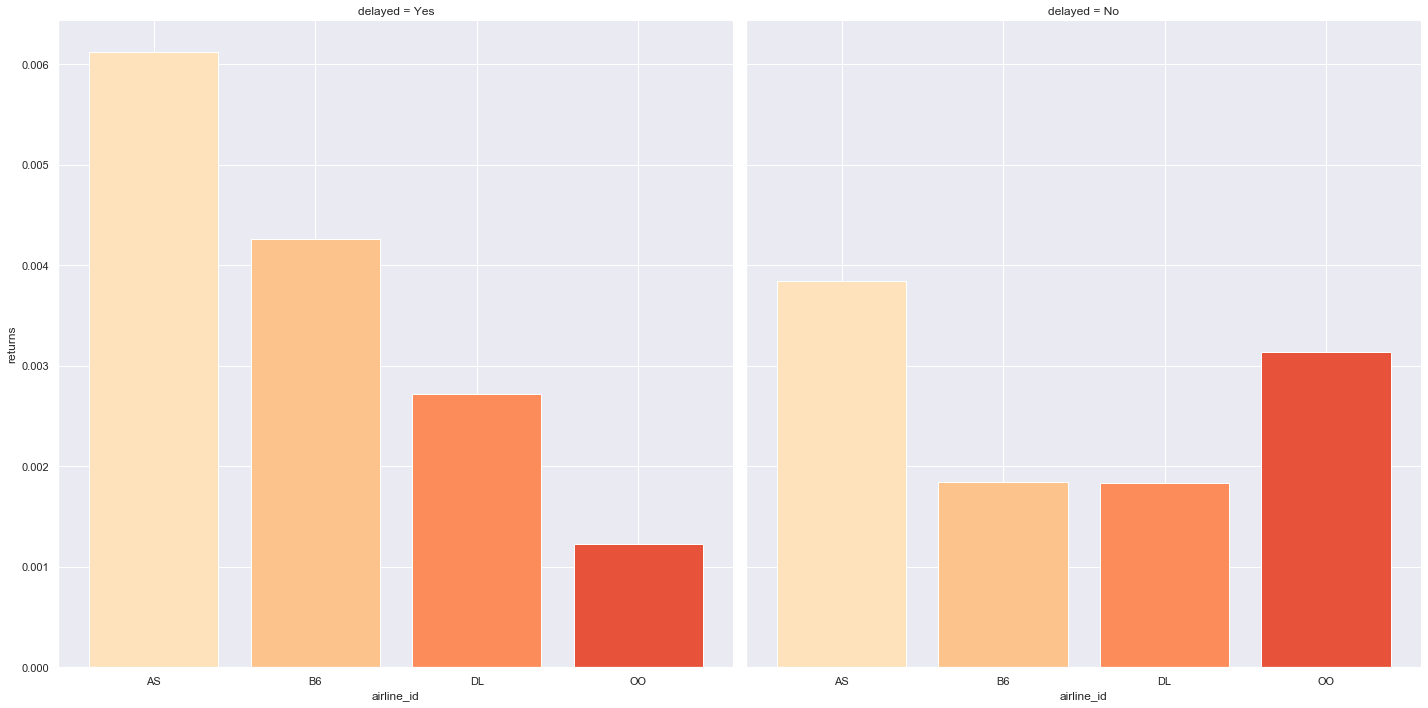

In [142]:
g = sns.FacetGrid(melted_delays, col="delayed",hue='airline_id',height=10,palette=sns.color_palette("OrRd", 5))
g.map(plt.bar, "airline_id", "returns")

In [78]:
statistic, pvalue = stats.ttest_ind(delayEvent[delayEvent.airline_id=='AS']['return'], 
                                    noDelayEvent[noDelayEvent.airline_id=='AS']['return'], equal_var=False)
print("P-value:",pvalue)

P-value: 0.43432756379007564


In [79]:
statistic, pvalue = stats.ttest_ind(delayEvent[delayEvent.airline_id=='B6']['return'], 
                                    noDelayEvent[noDelayEvent.airline_id=='B6']['return'], equal_var=False)
print("P-value:",pvalue)

P-value: 0.008899281383025778


In [80]:
statistic, pvalue = stats.ttest_ind(delayEvent[delayEvent.airline_id=='DL']['return'], 
                                    noDelayEvent[noDelayEvent.airline_id=='DL']['return'], equal_var=False)
print("P-value:",pvalue)

P-value: 0.25704876950980426


In [81]:
statistic, pvalue = stats.ttest_ind(delayEvent[delayEvent.airline_id=='OO']['return'], 
                                    noDelayEvent[noDelayEvent.airline_id=='OO']['return'], equal_var=False)
print("P-value:",pvalue)

P-value: 0.19691852997220097


In [84]:
updated_events['cancel_rate'].unique()

array([0.        , 0.09090909, 0.06666667, 1.        , 0.2       ,
       0.04761905, 0.14285714, 0.33333333, 0.5       , 0.18181818,
       0.08333333, 0.0625    , 0.07142857, 0.23076923, 0.11764706,
       0.07692308, 0.26666667, 0.16666667, 0.125     , 0.66666667,
       0.21428571, 0.375     , 0.25      , 0.1       , 0.35714286,
       0.41176471, 0.05882353, 0.11111111, 0.10526316, 0.15384615,
       0.03846154, 0.05555556, 0.58823529, 0.4       , 0.03030303,
       0.36363636, 0.13333333, 0.04347826, 0.03225806, 0.05263158,
       0.75      , 0.22222222, 0.46153846, 0.27777778, 0.78571429,
       0.15789474])

In [95]:
no_event_subset = stock_traffic[['airline_id','returns','delay_time']]
no_event_subset = no_event_subset.loc[no_event_subset['airline_id'].isin(['UA','WN'])]
no_event_subset.head()

,airline_id,returns,delay_time
11221,UA,-0.036281,0.0
11222,UA,-0.036281,0.0
11223,UA,-0.036281,0.0
11224,UA,-0.036281,0.0
11225,UA,-0.036281,0.0


In [96]:
delayNoEvent = no_event_subset[no_event_subset.delay_time>30]
noDelayNoEvent = no_event_subset[no_event_subset.delay_time<=30]

In [97]:
mean_delayNoEvent = delayNoEvent.groupby('airline_id')['returns'].mean().reset_index()
mean_delayNoEvent.columns = ['airline_id','Yes']
mean_noDelayNoEvent = noDelayNoEvent.groupby('airline_id')['returns'].mean().reset_index()
mean_noDelayNoEvent.columns = ['airline_id','No']
melted_Nodelays = pd.melt(pd.merge(mean_delayNoEvent,mean_noDelayNoEvent,on='airline_id'),id_vars=['airline_id'],
                        value_vars=['Yes','No'],
                        var_name='delayed',value_name='returns')
melted_Nodelays.head()

,airline_id,delayed,returns
0,UA,Yes,-0.000230
1,WN,Yes,-0.000153
2,UA,No,-0.000074
3,WN,No,0.001288


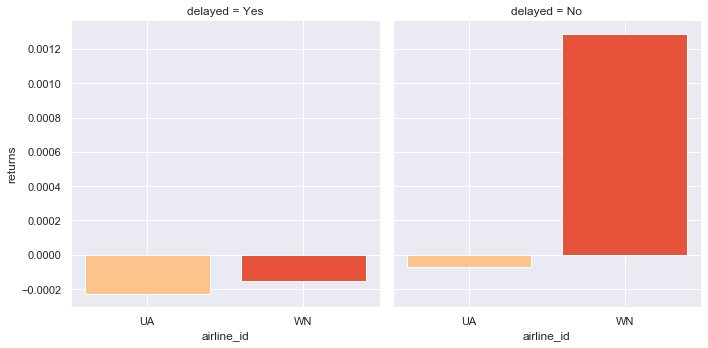

In [147]:
g = sns.FacetGrid(melted_Nodelays, col="delayed",hue='airline_id',height=5,palette=sns.color_palette("OrRd", 2))
g.map(plt.bar, "airline_id", "returns")

In [99]:
statistic, pvalue = stats.ttest_ind(delayNoEvent[delayNoEvent.airline_id=='UA']['returns'], 
                                    noDelayNoEvent[noDelayNoEvent.airline_id=='UA']['returns'], equal_var=False)
print("P-value:",pvalue)

P-value: 0.7660978536536829


In [101]:
statistic, pvalue = stats.ttest_ind(delayNoEvent[delayNoEvent.airline_id=='WN']['returns'], 
                                    noDelayNoEvent[noDelayNoEvent.airline_id=='WN']['returns'], equal_var=False)
print("P-value:",pvalue)

P-value: 1.0335695874534994e-06
